<img src="../images/full-jtech-d-15-0020_1-f4.jpg" width=700 alt="QVP plot"></img>

Courtesy: Rizhkov, et al. (2014)

# Quasi-Vertical Profile

---

Before running this notebook, complete the [2.NexRad2Zarr](2.NexRad2Zarr.ipynb) tutorial to create the NEXRAD data in Zarr format.

In [1]:
from pathlib import Path

import cmweather  # noqa: F401
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from raw2zarr.builder.builder_utils import get_icechunk_repo

## Load Zarr Data

Open the radar datatree from the Zarr store created in the previous notebook.

In [2]:
# Configuration
zarr_store = "../zarr/KVNX.zarr"

# Verify the Zarr store exists
if not Path(zarr_store).exists():
    raise FileNotFoundError(
        f"Zarr store not found at {zarr_store}. Please run the '2.NexRad2Zarr.ipynb' notebook first."
    )

Connect to the Icechunk repository using the utility function.

In [3]:
# Connect to the Icechunk repository
repo = get_icechunk_repo(zarr_store)

  2025-09-21T13:10:05.005444Z  WARN icechunk::storage::object_store: The LocalFileSystem storage is not safe for concurrent commits. If more than one thread/process will attempt to commit at the same time, prefer using object stores.
    at icechunk/src/storage/object_store.rs:80



Create a readonly session to access the data.

In [4]:
session = repo.readonly_session("main")

Open the radar datatree using xarray.

In [5]:
dtree = xr.open_datatree(
    session.store,
    engine="zarr",
    zarr_format=3,
    consolidated=False,
    chunks={},
)

Explore the available VCP patterns and elevation sweeps.

In [6]:
list(dtree["VCP-12"].children)

['sweep_1',
 'georeferencing_correction',
 'sweep_12',
 'sweep_0',
 'sweep_11',
 'sweep_10',
 'sweep_14',
 'sweep_15',
 'radar_parameters',
 'sweep_16',
 'sweep_13',
 'sweep_2',
 'sweep_3',
 'sweep_6',
 'sweep_4',
 'sweep_5',
 'sweep_8',
 'sweep_7',
 'sweep_9']

Select the highest elevation sweep for QVP computation. Use the last sweep (highest angle) available.

In [7]:
# Get available sweeps and select the highest elevation angle
available_sweeps = [
    child for child in dtree["VCP-12"].children if child.startswith("sweep_")
]
available_sweeps.sort(key=lambda x: int(x.split("_")[1]))  # Sort by sweep number

available_sweeps

['sweep_0',
 'sweep_1',
 'sweep_2',
 'sweep_3',
 'sweep_4',
 'sweep_5',
 'sweep_6',
 'sweep_7',
 'sweep_8',
 'sweep_9',
 'sweep_10',
 'sweep_11',
 'sweep_12',
 'sweep_13',
 'sweep_14',
 'sweep_15',
 'sweep_16']

In [8]:
# Use the highest numbered sweep (typically highest elevation)
highest_sweep = available_sweeps[-1]
print(f"Using {highest_sweep} for QVP computation")

ds_qvp = dtree[f"/VCP-12/{highest_sweep}"].ds

Using sweep_16 for QVP computation


## Compute Quasi-Vertical Profiles

Select data from the highest elevation sweep and time range of interest.

In [9]:
def compute_qvp(ds: xr.Dataset, var: str = "DBZH") -> xr.DataArray:
    """
    Compute Quasi-Vertical Profile (QVP) by averaging over azimuth.

    Parameters:
    -----------
    ds : xr.Dataset
        Radar dataset containing the variable
    var : str
        Variable name to compute QVP for

    Returns:
    --------
    xr.DataArray
        QVP with height coordinate computed from range and elevation
    """
    if var not in ds.data_vars:
        raise ValueError(f"Variable '{var}' not found in dataset")

    units = ds[var].attrs.get("units", "")

    # Convert dB values to linear, average, then convert back
    if units.startswith("dB"):
        qvp = 10 ** (ds[var] / 10)
        qvp = qvp.mean("azimuth", skipna=True)
        qvp = 10 * np.log10(qvp)
    else:
        qvp = ds[var].mean("azimuth", skipna=True)

    # Compute height from range and elevation angle
    elevation_rad = ds.sweep_fixed_angle.mean(skipna=True).values * np.pi / 180.0
    height_km = qvp.range.values * np.sin(elevation_rad) / 1000

    # Update coordinates and naming
    qvp = qvp.assign_coords(range=height_km)
    qvp = qvp.rename({"range": "height"})
    qvp.name = f"qvp_{var}"

    return qvp

Compute QVP for multiple radar variables.

In [10]:
%%time
# Compute QVP for multiple radar variables
variables = ["DBZH", "ZDR", "RHOHV", "PHIDP"]
qvp_data = {}

for var in variables:
    if var in ds_qvp.data_vars:
        qvp_data[var] = compute_qvp(ds_qvp, var=var).compute()
        print(f"Computed QVP for {var}")
    else:
        print(f"Warning: Variable {var} not found in dataset")

print(f"Successfully computed QVP for {len(qvp_data)} variables")

Computed QVP for DBZH
Computed QVP for ZDR
Computed QVP for RHOHV
Computed QVP for PHIDP
Successfully computed QVP for 4 variables
CPU times: user 1.35 s, sys: 156 ms, total: 1.5 s
Wall time: 765 ms


Create time-height plots for the computed QVP variables.

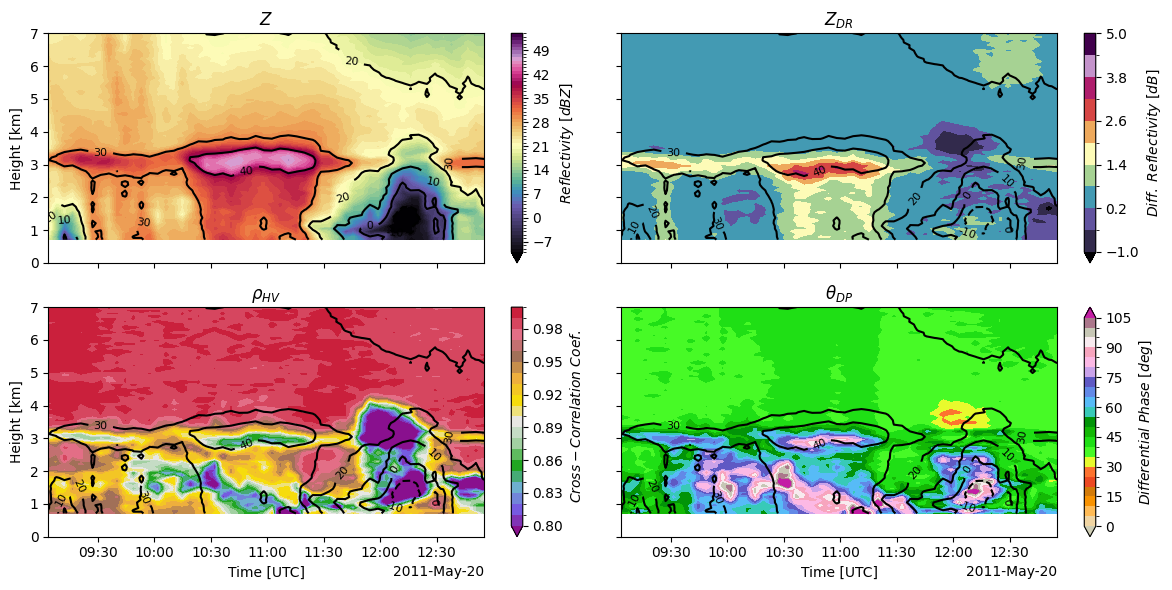

CPU times: user 1.07 s, sys: 35.9 ms, total: 1.11 s
Wall time: 1.16 s


In [11]:
%%time
fig, axs = plt.subplots(2, 2, figsize=(12, 6), sharey=True, sharex=True)

# Define plot configurations
plot_configs = [
    {
        "var": "DBZH",
        "title": r"$Z$",
        "cmap": "ChaseSpectral",
        "levels": np.arange(-10, 55, 1),
        "label": r"$Reflectivity \ [dBZ]$",
    },
    {
        "var": "ZDR",
        "title": r"$Z_{DR}$",
        "cmap": "ChaseSpectral",
        "levels": np.linspace(-1, 5, 11),
        "label": r"$Diff. \ Reflectivity \ [dB]$",
    },
    {
        "var": "RHOHV",
        "title": r"$\rho _{HV}$",
        "cmap": "Carbone11",
        "levels": np.arange(0.8, 1.01, 0.01),
        "label": r"$Cross-Correlation \ Coef.$",
    },
    {
        "var": "PHIDP",
        "title": r"$\theta _{DP}$",
        "cmap": "PD17",
        "levels": np.arange(0, 110, 5),
        "label": r"$Differential \ Phase \ [deg]$",
    },
]

# Create subplots
for i, config in enumerate(plot_configs):
    row, col = i // 2, i % 2
    var = config["var"]

    if var not in qvp_data:
        axs[row, col].text(
            0.5,
            0.5,
            f"{var}\nNot Available",
            ha="center",
            va="center",
            transform=axs[row, col].transAxes,
        )
        axs[row, col].set_title(config["title"])
        continue

    # Plot filled contours
    cf = qvp_data[var].plot.contourf(
        x="vcp_time",
        y="height",
        cmap=config["cmap"],
        levels=config["levels"],
        ax=axs[row, col],
        add_colorbar=False,
    )

    # Add reflectivity contour lines for reference
    if "DBZH" in qvp_data:
        contour_lines = qvp_data["DBZH"].plot.contour(
            x="vcp_time",
            y="height",
            colors="k",
            levels=np.arange(-10, 50, 10),
            ax=axs[row, col],
        )
        axs[row, col].clabel(contour_lines, fmt="%d", inline=True, fontsize=8)

    axs[row, col].set_title(config["title"])
    axs[row, col].set_ylim(0, 7)

    # Set labels
    if row == 1:
        axs[row, col].set_xlabel("Time [UTC]")
    else:
        axs[row, col].set_xlabel("")

    if col == 0:
        axs[row, col].set_ylabel("Height [km]")
    else:
        axs[row, col].set_ylabel("")

    # Add colorbar
    plt.colorbar(cf, ax=axs[row, col], label=config["label"])

fig.tight_layout()
plt.show()

---

## Summary

This notebook demonstrated creating Quasi-Vertical Profiles (QVPs) from NEXRAD data:

1. **Data Loading**: Accessed hierarchical Zarr data with proper validation
2. **QVP Computation**: Used highest elevation sweep for vertical profiling
3. **Visualization**: Created time-height plots for multiple radar variables

The QVP analysis reveals storm structure evolution during the May 20, 2011 tornado outbreak, showing vertical distribution of precipitation and microphysical properties.

## References

* Ryzhkov, A., P. Zhang, H. Reeves, M. Kumjian, T. Tschallener, S. Trömel, and C. Simmer, 2016: Quasi-Vertical Profiles—A New Way to Look at Polarimetric Radar Data. J. Atmos. Oceanic Technol., 33, 551–562, https://doi.org/10.1175/JTECH-D-15-0020.1.